In [1]:
import numpy as np
import matplotlib.pyplot as plt

from imp import reload
import sys
sys.path.insert(0, '..')
import utilities as ut

from skimage import img_as_float
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.measure import grid_points_in_poly

In [5]:
reload(ut)

<module 'utilities' from '../utilities.py'>

# Data Preparation

In [29]:
hst = img_as_float(ut.read_hyperstack('../data/wt_gbe_20180110.h5'))

In [2]:
center_x,center_y = 500,530
radius_x,radius_y = 550,250
ellipse = ut.calc_ellipse(center_x,center_y,radius_x,radius_y)

In [6]:
# Loop through each timepoint in hyperstack to create mask
for t in range(hst.shape[0]):
    hst[t] = ut.contour_embryo(hst[t],ellipse)

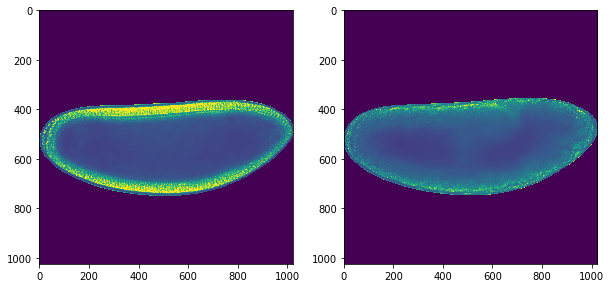

In [7]:
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(hst[0])
ax[1].imshow(hst[-1])

In [9]:
import h5py

In [10]:
# Open new h5py file to add data to
f = h5py.File('../data/wt_gbe_20180110_mask.h5','w')

# Save each timepoint to a group/dataset in h5 file
for t in range(hst.shape[0]):
    f.create_dataset('t'+str(t)+'/channel1', data=hst[t])
    
# close file
f.close()

In [28]:
mhst = hst.copy()

# Use contour to create bins?

In [30]:
# single time point for testing
img = hst[0]

Calculate contour based on unmasked image

In [31]:
snake = active_contour(gaussian(img, 3),
                       ellipse, alpha=0.015, beta=10, gamma=0.001)

In [13]:
snake.shape

(400, 2)

Divide contour into 20pt segments. Could these segments be used to assign bins to the embryo? 

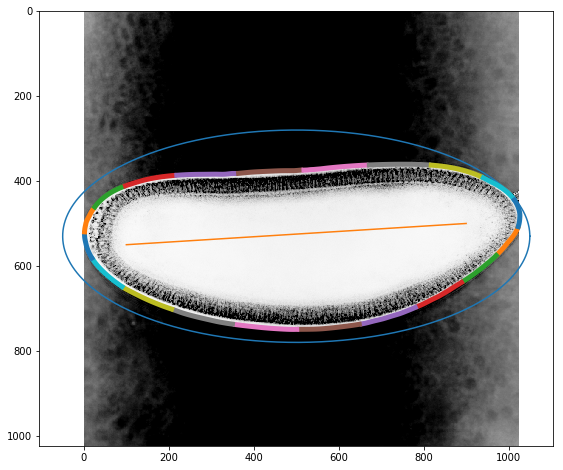

In [38]:
fig,ax = plt.subplots(figsize=(10,8))
ax.imshow(img,cmap='Greys')
ax.plot(ellipse[:,0],ellipse[:,1])
for i in range(20,401,20):
    ax.plot(snake[i-20:i,0],snake[i-20:i,1],lw=5)
ax.plot([100,900],[550,500])

Reassign `img` as masked image for calculates and assign background points (=0) to be `np.nan`.

In [43]:
img = mhst[0]
img[img==0] = np.nan

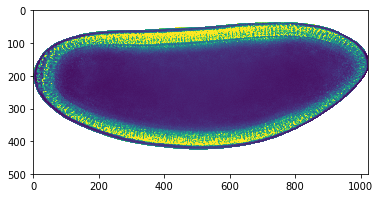

In [44]:
# Crop image to reduce the number of points for processing
imgc = img[int(snake[:,1].min()*0.9) : int(snake[:,1].max()*1.1),
          int(snake[:,0].min()*0.9) : int(snake[:,0].max()*1.1)]

plt.imshow(imgc)

Divide x axis into 20 segments

In [46]:
xgrid = np.linspace(0,1024,20).astype(int)
xgrid

array([   0.,   54.,  108.,  162.,  216.,  269.,  323.,  377.,  431.,
        485.,  539.,  593.,  647.,  701.,  755.,  808.,  862.,  916.,
        970., 1024.])

In [85]:
ygrid = np.array([0,180,500])
ygrid

array([  0, 180, 500])

Create an roi mask that assigns each chunk of the grid a unqiue integer

In [73]:
# Split image into a grid
rois = np.zeros_like(imgc)

n=1
for j in range(len(ygrid)-1):
    y = ygrid[j]
    ydt = ygrid[j+1]
    for i in range(len(xgrid)-1):
        x = xgrid[i]
        xdt = xgrid[i+1]
        
        if j > 0:
            xdt = xgrid[-i-1]
            x = xgrid[-i-2]
            
        print(n,x,xdt,y,ydt)
#         print(n)
        rois[y:ydt,x:xdt] = n
        n = n+1

1 0 53 0 180
2 53 107 0 180
3 107 161 0 180
4 161 215 0 180
5 215 269 0 180
6 269 323 0 180
7 323 377 0 180
8 377 431 0 180
9 431 485 0 180
10 485 538 0 180
11 538 592 0 180
12 592 646 0 180
13 646 700 0 180
14 700 754 0 180
15 754 808 0 180
16 808 862 0 180
17 862 916 0 180
18 916 970 0 180
19 970 1024 0 180
20 970 1024 180 500
21 916 970 180 500
22 862 916 180 500
23 808 862 180 500
24 754 808 180 500
25 700 754 180 500
26 646 700 180 500
27 592 646 180 500
28 538 592 180 500
29 485 538 180 500
30 431 485 180 500
31 377 431 180 500
32 323 377 180 500
33 269 323 180 500
34 215 269 180 500
35 161 215 180 500
36 107 161 180 500
37 53 107 180 500
38 0 53 180 500


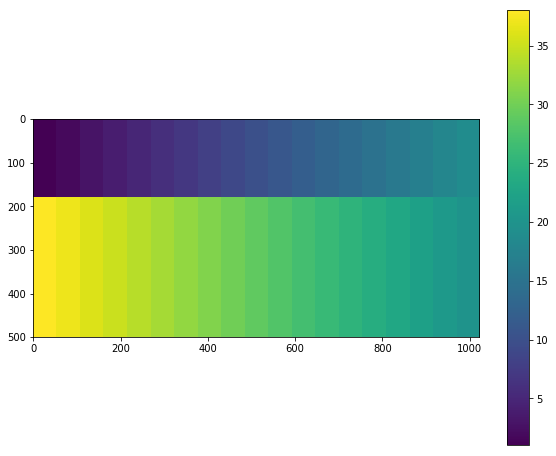

In [86]:
ut.imshow(rois)

In [75]:
nroi = np.unique(rois).shape
nroi

(38,)

Calculate the average intensity value in each roi bin

In [82]:
avgs = []
for n in range(1,nroi[0]+1):
    avgs.append(np.nanmean(imgc[rois==n]))

In [83]:
avgs

[0.4427069060476793,
 0.46647495066448147,
 0.3974978539693559,
 0.42014871578232893,
 0.43905225921143404,
 0.47492665319469685,
 0.49936998579399805,
 0.5043896368046159,
 0.4959334351938998,
 0.4921885501781409,
 0.47233021745974046,
 0.4673157459295516,
 0.46256143366632324,
 0.4461651983888981,
 0.4071966905061887,
 0.3908699405953789,
 0.39430106041454,
 0.39689340044712296,
 0.4389655600464222,
 0.4008267078364833,
 0.36525696563783827,
 0.3358210822445556,
 0.3250315421378059,
 0.3341720817545782,
 0.33488973505498476,
 0.329089115694154,
 0.33495149609058217,
 0.3403805108193431,
 0.3426008149376014,
 0.3403344864741334,
 0.33622586696205126,
 0.3323249551089294,
 0.32533391654571336,
 0.32449243748028983,
 0.32504733634007604,
 0.3292835775358699,
 0.39005980472951957,
 0.4566069154319581]

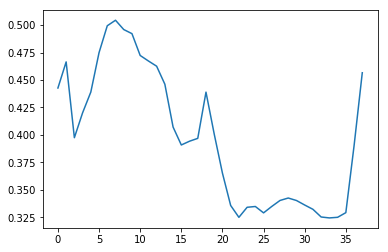

In [84]:
plt.plot(avgs)

The second half of rois appear to have reduced signal because those bins include more points of the center of the embryo compared to the first half of rois. In this case, `np.nanmean` is not appropriate unless there is some way to normalize the number of points that are included from the center of the embryo.

Is there a way to shrink the contour line inward to catch just the layer of cells and exclude the majority of the center of the embryo? 

A crude brute force calculation could calculate the derivative at each point in the contour and shift the point along the perpendicular to the curve.

At some point I need to think about if I should normalize every image before starting this part of analysis.